In [1]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

In [2]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=5     # which GPU to use
plot=False # Plot Intermediate results
sigma=7.5   # Initial model smoothness  

# Inversion parameters
num_batches = 4
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 14
dx = 10
dt = 0.001
nt = 4001
num_shots = 16
num_receivers_per_shot = 201

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

In [3]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
from sklearn.feature_extraction import image
from skimage.transform import resize

In [4]:
NX = 800;
NY = 186;
DH = 25.0;
f = open("AllModels/overthrust_true.vp")
data_type = np.dtype ('float32').newbyteorder ('<')
overthrust = np.fromfile (f, dtype=data_type)
overthrust = overthrust.reshape(NX,NY)
#overthrust = np.transpose(overthrust)
#overthrust = overthrust[0:130,0:550]
#overthrust = resize(overthrust, (151, 201))
#mat = overthrust

In [5]:
np.shape(overthrust)

(800, 186)

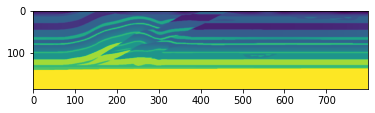

In [6]:
plt.imshow(np.transpose(overthrust))

In [126]:
plot=True
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max1=np.max(mat)
min1=np.min(mat)
med=(max1+min1)/2.
wid=(max1-min1)/2.

print('vmin=',min1,'vmax=',max1,'vmed=',med,'vwidth=',wid)

vmin= 2414.9575 vmax= 5500.0 vmed= 3957.478759765625 vwidth= 1542.521240234375


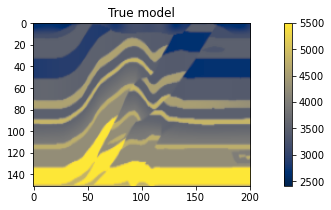

In [127]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat,vmin=min1,vmax=max1, aspect=1,cmap='cividis')
    plt.title('True model')
    plt.colorbar()

In [128]:
#RB Open file to write results
f = open('marmsm_Mod8_log.txt','a+')
writer = csv.writer(f)

#RB Write header
fields=['Epoch','it','loss.item','epoch_loss','it_lap','epoch_lap']
writer.writerow(fields)
f.flush()
os.fsync(f)

In [129]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [130]:
# Set parameters
num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)


ny= 201 nz= 151 nt= 4001 dx= 10 freq= 14
shots= 16 recs/shot= 201 ds= 125.625 dr= 10.0


In [131]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
#x_s[:, 0, 0] = 100. #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [132]:
#RB Generate a cte velocy model (with water velocity)
mat2 = np.ones((nz,ny),np.float32)*1500.

mat2[nz-1,int(ny/2)]=max1  # put a pixel with true upper velocity to fix a propagator problem

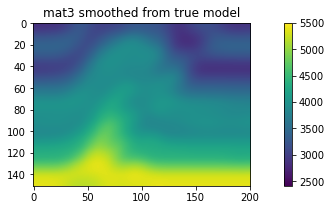

In [133]:
#RB Create a smoothed model

#RB start with true model
mat3 = np.copy(mat)
#RB Filter image heavly
mat3 = scipy.ndimage.gaussian_filter(mat3,sigma=sigma) #10,50  #5%,10%
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat3,vmin=min1,vmax=max1)
    plt.title('mat3 smoothed from true model')
    plt.colorbar()
    
#mat3 = 2200*np.ones(np.shape(mat))
#RB Force water table to be 1500 m/s (avoid imperfect direct wav removal)    
#mat3[0:26,:]=1500.

#RB Plot model
#if plot==True:
#    plt.figure(figsize=(12, 3))
#    plt.imshow(mat3,vmin=min1,vmax=max1)
#    plt.title('mat3 fixed water table')
#    plt.colorbar()

#RB We may want to smooth the water table transition
#RB but I think it's a bad idea (not tested)
# mat3 = scipy.ndimage.gaussian_filter(mat3,sigma=4)

#RB Optionally we may import a initial model from file
#filename='Marm151_401_smooth.mat'
#mat3=scipy.io.loadmat(filename)['vel0']

#RB Ensure that the initial model has the same range of the true model by
#RB forcing one of its slowest pixel to have the true's model lower velocity and
#RB forcing one of its fastest pixel to have the true's model upper velocity
#RB find max & min values of mat3
smin=np.min(mat3)
smax=np.max(mat3)
indmin = np.where(mat3==smin)
indmax = np.where(mat3==smax)
# Take first pixel with minimum velocity and force it to true's model minimum velocity
mat3[indmin[0][0],indmin[1][0]]=min1
# Take first pixel with maximum velocity and force it to true's model maximum velocity
mat3[indmax[0][0],indmax[1][0]]=max1

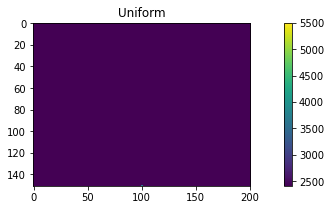

In [134]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat2,vmin=min1,vmax=max1, aspect=1)
    plt.title('Uniform')
    plt.colorbar()

In [135]:
#RB Convert models to PyTorch Tensors
model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
model_cte = torch.Tensor(mat2) # Convert to a PyTorch Tensor

In [136]:
###### Create 'true' data 
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
seis=np.squeeze(receiver_amplitudes_all.cpu().detach().numpy())
#seis = seis.swapaxes(1,2)
#seis = seis.swapaxes(0,1)
#receiver_amplitudes_all = receiver_amplitudes_all.swapaxes(1,2)

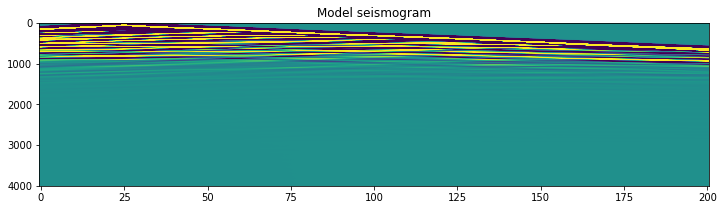

In [137]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram')

In [138]:
# Exclude direct waves from true data (they don't bring info from subsurface)
receiver_amplitudes_true = receiver_amplitudes_all

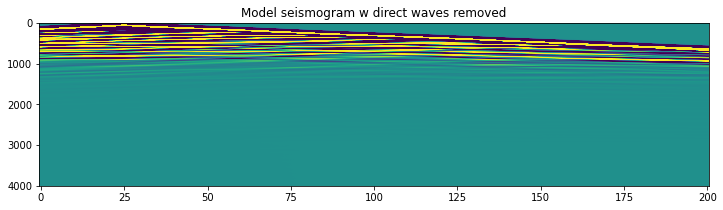

In [139]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_true[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram w direct waves removed')

In [140]:
#RB Normalize initial model to (-1,1) range
#model_init = (mat3-med)/wid
#RB_No_normalization
model_init = mat3

In [141]:
# Convert to Pytorch tensor
#model_init = torch.from_numpy(np.float32(model_init))
model_init = torch.Tensor(model_init)

# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True

In [142]:
#RB AS I am not inverting for source, I could just do
#RB source_amplitudes = source_amplitudes_true.clone().to(device)
#RB instead of all code below

# Create initial guess source amplitude for inversion
# I will assume that the true source amplitude is the same for every shot
# so I will just create one source amplitude, and PyTorch will backpropagate
# updates to it from every shot
source_amplitudes_init = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1))
source_amplitudes = source_amplitudes_init.clone()
source_amplitudes = source_amplitudes.to(device)
#source_amplitudes.requires_grad_(); # Alternative way of requiring gradient

In [143]:
# To demonstrate chaining operations, during the inversion I will normalise the
# predicted receiver amplitudes so that each trace has a maximum value of 1.
# This will be compared (in the cost function) with the true data that has been
# similarly scaled. I apply that scaling to the true data now.
# This sort of scaling might be useful for real data where the absolute
# amplitudes are often not meaningful.
rcv_amps_true_max, _ = receiver_amplitudes_true.max(dim=0, keepdim=True)
rcv_amps_true_norm = receiver_amplitudes_true / rcv_amps_true_max

In [144]:
# Set-up inversion
#gamma = 300
criterion = torch.nn.MSELoss()
#RB optimizer = torch.optim.SGD([{'params': model }],lr = 100000., momentum=0)
optimizer = torch.optim.Adam([{'params': [model], 'lr': lr}])

Processing Epoch: 0
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 0 Loss:  0.020094629377126694


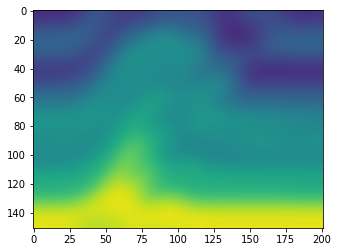

Processing Epoch: 1
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1 Loss:  0.01832658238708973
Processing Epoch: 2
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2 Loss:  0.016488796565681696
Processing Epoch: 3
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3 Loss:  0.014845825266093016
Processing Epoch: 4
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4 Loss:  0.013156838715076447
Processing Epoch: 5
shape of predicte

Epoch: 34 Loss:  0.0023225366603583097
Processing Epoch: 35
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 35 Loss:  0.0022679047542624176
Processing Epoch: 36
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 36 Loss:  0.0022145350521896034
Processing Epoch: 37
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 37 Loss:  0.002163902739994228
Processing Epoch: 38
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 38 Loss:  0.002114

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 68 Loss:  0.0012922725290991366
Processing Epoch: 69
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 69 Loss:  0.0012742379331029952
Processing Epoch: 70
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 70 Loss:  0.0012583294010255486
Processing Epoch: 71
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 71 Loss:  0.0012428527406882495
Processing Epoch: 72
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 102 Loss:  0.0009676179324742407
Processing Epoch: 103
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 103 Loss:  0.0009624647645978257
Processing Epoch: 104
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 104 Loss:  0.0009564736974425614
Processing Epoch: 105
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 105 Loss:  0.0009506320348009467
Processing Epoch: 106
shape of predicted
torch.Size([4001, 4, 100])
shape of predict

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 135 Loss:  0.0008229827071772888
Processing Epoch: 136
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 136 Loss:  0.0008194530819309875
Processing Epoch: 137
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 137 Loss:  0.0008162778249243274
Processing Epoch: 138
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 138 Loss:  0.0008130542264552787
Processing Epoch: 139
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predict

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 169 Loss:  0.0007295796094695106
Processing Epoch: 170
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 170 Loss:  0.000727176564396359
Processing Epoch: 171
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 171 Loss:  0.0007249556365422904
Processing Epoch: 172
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 172 Loss:  0.0007228240283438936
Processing Epoch: 173
shape of predicte

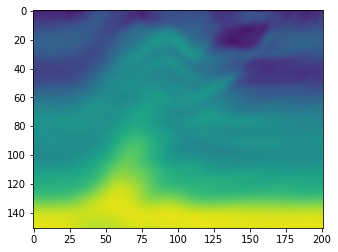

Processing Epoch: 201
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 201 Loss:  0.0006653527962043881
Processing Epoch: 202
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 202 Loss:  0.0006636805628659204
Processing Epoch: 203
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 203 Loss:  0.0006617788749281317
Processing Epoch: 204
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 204 Loss:  0.0006601236673304811
Processing Epoch

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 234 Loss:  0.0006128035674919374
Processing Epoch: 235
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 235 Loss:  0.0006113495182944462
Processing Epoch: 236
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 236 Loss:  0.000609965376497712
Processing Epoch: 237
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 237 Loss:  0.00060853231116198
Processing Epoch: 238
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted


Epoch: 267 Loss:  0.0005692139093298465
Processing Epoch: 268
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 268 Loss:  0.0005679865062120371
Processing Epoch: 269
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 269 Loss:  0.0005667839359375648
Processing Epoch: 270
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 270 Loss:  0.0005656087523675524
Processing Epoch: 271
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 271 Loss:

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 301 Loss:  0.0005310180495143868
Processing Epoch: 302
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 302 Loss:  0.0005299344848026522
Processing Epoch: 303
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 303 Loss:  0.0005288908505463041
Processing Epoch: 304
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 304 Loss:  0.0005278839016682468
Processing Epoch: 305
shape of predicted
torch.Size([4001, 4, 100])
shape of predict

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 334 Loss:  0.0004987227221135981
Processing Epoch: 335
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 335 Loss:  0.0004977781936759129
Processing Epoch: 336
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 336 Loss:  0.0004968752182321623
Processing Epoch: 337
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 337 Loss:  0.0004959237194270827
Processing Epoch: 338
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predict

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 368 Loss:  0.00046933234989410266
Processing Epoch: 369
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 369 Loss:  0.0004684646337409504
Processing Epoch: 370
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 370 Loss:  0.0004677199976867996
Processing Epoch: 371
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 371 Loss:  0.00046687712892889977
Processing Epoch: 372
shape of predi

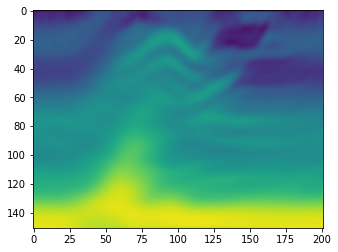

Processing Epoch: 401
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 401 Loss:  0.00044383976637618616
Processing Epoch: 402
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 402 Loss:  0.00044311422971077263
Processing Epoch: 403
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 403 Loss:  0.00044241052091820166
Processing Epoch: 404
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 404 Loss:  0.00044165641884319484
Processing E

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 434 Loss:  0.00042086569737875834
Processing Epoch: 435
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 435 Loss:  0.00042020552791655064
Processing Epoch: 436
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 436 Loss:  0.00041960042290156707
Processing Epoch: 437
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 437 Loss:  0.000418887022533454
Processing Epoch: 438
shape of predicted
torch.Size([4001, 4, 100])
shape of predi

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 467 Loss:  0.00040003625326789916
Processing Epoch: 468
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 468 Loss:  0.00039945743628777564
Processing Epoch: 469
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 469 Loss:  0.00039888699393486604
Processing Epoch: 470
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 470 Loss:  0.00039822873804951087
Processing Epoch: 471
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of pre

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 501 Loss:  0.0003804658699664287
Processing Epoch: 502
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 502 Loss:  0.0003799554397119209
Processing Epoch: 503
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 503 Loss:  0.0003793593277805485
Processing Epoch: 504
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 504 Loss:  0.0003788436370086856
Processing Epoch: 505
shape of predict

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 534 Loss:  0.00036309398274170235
Processing Epoch: 535
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 535 Loss:  0.00036255123995942995
Processing Epoch: 536
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 536 Loss:  0.00036208016535965726
Processing Epoch: 537
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 537 Loss:  0.00036155249836156145
Processing Epoch: 538
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of pre

Epoch: 567 Loss:  0.00034708659222815186
Processing Epoch: 568
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 568 Loss:  0.0003465978370513767
Processing Epoch: 569
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 569 Loss:  0.00034616278571775183
Processing Epoch: 570
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 570 Loss:  0.0003456770209595561
Processing Epoch: 571
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 571 Los

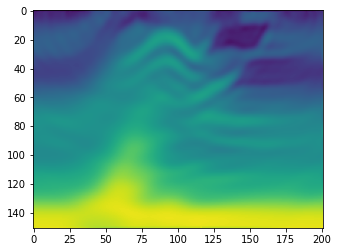

Processing Epoch: 601
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 601 Loss:  0.00033191228430951014
Processing Epoch: 602
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 602 Loss:  0.0003314460554975085
Processing Epoch: 603
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 603 Loss:  0.00033101685403380543
Processing Epoch: 604
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 604 Loss:  0.0003306307080492843
Processing Epo

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 634 Loss:  0.0003182136752002407
Processing Epoch: 635
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 635 Loss:  0.000317826219543349
Processing Epoch: 636
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 636 Loss:  0.0003174418452545069
Processing Epoch: 637
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 637 Loss:  0.0003170171876263339
Processing Epoch: 638
shape of predicted
torch.Size([4001, 4, 100])
shape of predicte

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 667 Loss:  0.00030552007592632435
Processing Epoch: 668
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 668 Loss:  0.00030513943784171715
Processing Epoch: 669
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 669 Loss:  0.0003047563041036483
Processing Epoch: 670
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 670 Loss:  0.00030443345167441294
Processing Epoch: 671
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of pred

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 701 Loss:  0.0002933573523478117
Processing Epoch: 702
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 702 Loss:  0.00029300629830686375
Processing Epoch: 703
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 703 Loss:  0.0002926771412603557
Processing Epoch: 704
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 704 Loss:  0.00029234356043161824
Processing Epoch: 705
shape of predi

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 734 Loss:  0.0002823538343363907
Processing Epoch: 735
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 735 Loss:  0.00028200916858622804
Processing Epoch: 736
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 736 Loss:  0.0002817360946210101
Processing Epoch: 737
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 737 Loss:  0.00028137876506661996
Processing Epoch: 738
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predi

Epoch: 767 Loss:  0.0002720889824558981
Processing Epoch: 768
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 768 Loss:  0.0002717431452765595
Processing Epoch: 769
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 769 Loss:  0.0002714557194849476
Processing Epoch: 770
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 770 Loss:  0.0002711637644097209
Processing Epoch: 771
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 771 Loss:

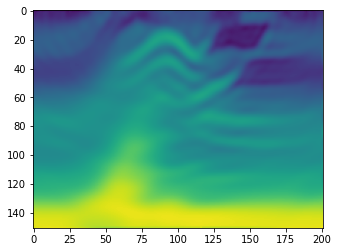

Processing Epoch: 801
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 801 Loss:  0.00026212475495412946
Processing Epoch: 802
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 802 Loss:  0.00026182609872194007
Processing Epoch: 803
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 803 Loss:  0.0002615408011479303
Processing Epoch: 804
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 804 Loss:  0.0002612724019854795
Processing Epo

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 834 Loss:  0.0002530638921598438
Processing Epoch: 835
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 835 Loss:  0.0002527986689528916
Processing Epoch: 836
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 836 Loss:  0.000252554800681537
Processing Epoch: 837
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 837 Loss:  0.0002522627037251368
Processing Epoch: 838
shape of predicted
torch.Size([4001, 4, 100])
shape of predicte

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 867 Loss:  0.0002445609061396681
Processing Epoch: 868
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 868 Loss:  0.00024431358542642556
Processing Epoch: 869
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 869 Loss:  0.00024407261298620142
Processing Epoch: 870
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 870 Loss:  0.00024382201809203252
Processing Epoch: 871
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of pred

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 901 Loss:  0.00023630563373444602
Processing Epoch: 902
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 902 Loss:  0.00023608671472175047
Processing Epoch: 903
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 903 Loss:  0.0002358396304771304
Processing Epoch: 904
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 904 Loss:  0.000235622632317245
Processing Epoch: 905
shape of predic

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 934 Loss:  0.00022876387447468005
Processing Epoch: 935
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 935 Loss:  0.00022855130009702407
Processing Epoch: 936
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 936 Loss:  0.0002283309804624878
Processing Epoch: 937
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 937 Loss:  0.00022809574147686362
Processing Epoch: 938
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of pred

Epoch: 967 Loss:  0.00022164804249769077
Processing Epoch: 968
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 968 Loss:  0.0002214319429185707
Processing Epoch: 969
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 969 Loss:  0.0002212160652561579
Processing Epoch: 970
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 970 Loss:  0.0002210187230957672
Processing Epoch: 971
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 971 Loss

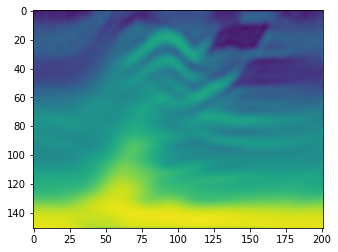

Processing Epoch: 1001
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1001 Loss:  0.00021470198771567084
Processing Epoch: 1002
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1002 Loss:  0.00021452691362355836
Processing Epoch: 1003
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1003 Loss:  0.00021430364722618833
Processing Epoch: 1004
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1004 Loss:  0.00021411748457467183
Proc

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1034 Loss:  0.00020830637731705792
Processing Epoch: 1035
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1035 Loss:  0.0002081169695884455
Processing Epoch: 1036
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1036 Loss:  0.0002079315745504573
Processing Epoch: 1037
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1037 Loss:  0.00020773975120391697
Processing Epoch: 1038
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1067 Loss:  0.00020223742467351258
Processing Epoch: 1068
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1068 Loss:  0.00020205197870382108
Processing Epoch: 1069
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1069 Loss:  0.000201878141524503
Processing Epoch: 1070
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1070 Loss:  0.00020170647258055396
Processing Epoch: 1071
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1100 Loss:  0.0001964856346603483
Processing Epoch: 1101
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1101 Loss:  0.00019630716269603
Processing Epoch: 1102
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1102 Loss:  0.00019614693155745044
Processing Epoch: 1103
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1103 Loss:  0.00019599005827330984
Processing Epoch: 1104
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1133 Loss:  0.00019101460929960012
Processing Epoch: 1134
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1134 Loss:  0.00019085120220552199
Processing Epoch: 1135
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1135 Loss:  0.00019067863104282878
Processing Epoch: 1136
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1136 Loss:  0.0001905185890791472
Processing Epoch: 1137
shape

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1166 Loss:  0.0001857918468886055
Processing Epoch: 1167
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1167 Loss:  0.00018564857964520343
Processing Epoch: 1168
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1168 Loss:  0.00018550290405983105
Processing Epoch: 1169
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1169 Loss:  0.00018535387789597735
Processing Epoch: 1170
shape

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1199 Loss:  0.0001808491397241596
Processing Epoch: 1200
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1200 Loss:  0.0001806979598768521


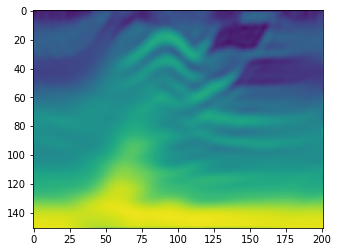

Processing Epoch: 1201
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1201 Loss:  0.00018054962129099295
Processing Epoch: 1202
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1202 Loss:  0.00018040921713691205
Processing Epoch: 1203
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1203 Loss:  0.00018026276666205376
Processing Epoch: 1204
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1204 Loss:  0.00018011733118328266
Proc

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1234 Loss:  0.0001758369071467314
Processing Epoch: 1235
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1235 Loss:  0.00017570448835613206
Processing Epoch: 1236
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1236 Loss:  0.00017555924205225892
Processing Epoch: 1237
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1237 Loss:  0.0001754228287609294
Processing Epoch: 1238
shape of predicted
torch.Size([4001, 4, 100])
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1267 Loss:  0.0001713414276309777
Processing Epoch: 1268
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1268 Loss:  0.0001712227713142056
Processing Epoch: 1269
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1269 Loss:  0.000171080777363386
Processing Epoch: 1270
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1270 Loss:  0.00017095172188419383
Processing Epoch: 1271
shape of predicted
torch.Size([4001, 4, 100])
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1300 Loss:  0.00016705641064618248
Processing Epoch: 1301
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1301 Loss:  0.00016693469660822302
Processing Epoch: 1302
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1302 Loss:  0.00016680136832292192
Processing Epoch: 1303
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1303 Loss:  0.000166669167811051
Processing Epoch: 1304
shape of predicted
torch.Size([4001, 4, 100])
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1333 Loss:  0.0001629666494409321
Processing Epoch: 1334
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1334 Loss:  0.0001628302579774754
Processing Epoch: 1335
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1335 Loss:  0.00016271004642476328
Processing Epoch: 1336
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1336 Loss:  0.00016258685172942933
Processing Epoch: 1337
shape of predicted
torch.Size([4001, 4, 100])
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1366 Loss:  0.00015905287364148535
Processing Epoch: 1367
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1367 Loss:  0.00015892127521510702
Processing Epoch: 1368
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1368 Loss:  0.0001587992774148006
Processing Epoch: 1369
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1369 Loss:  0.00015868885566305835
Processing Epoch: 1370
shape of predicted
torch.Size([4001, 4, 100])
shape

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1399 Loss:  0.00015528311632806435
Processing Epoch: 1400
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1400 Loss:  0.0001551752575323917


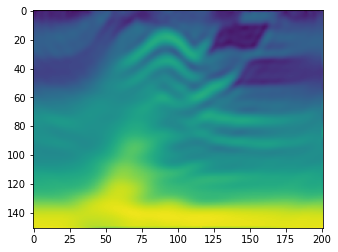

Processing Epoch: 1401
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1401 Loss:  0.0001550574761495227
Processing Epoch: 1402
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1402 Loss:  0.00015494915896852035
Processing Epoch: 1403
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1403 Loss:  0.00015483282186323777
Processing Epoch: 1404
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1404 Loss:  0.00015472335871891119
Proce

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1434 Loss:  0.00015147585327213164
Processing Epoch: 1435
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1435 Loss:  0.00015137224909267388
Processing Epoch: 1436
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1436 Loss:  0.00015126466314541176
Processing Epoch: 1437
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1437 Loss:  0.0001511597292847
Processing Epoch: 1438
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1467 Loss:  0.0001480361752328463
Processing Epoch: 1468
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1468 Loss:  0.00014794167873333208
Processing Epoch: 1469
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1469 Loss:  0.0001478353897255147
Processing Epoch: 1470
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1470 Loss:  0.00014773178918403573
Processing Epoch: 1471
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1500 Loss:  0.00014474264571617823
Processing Epoch: 1501
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1501 Loss:  0.00014464058767771348
Processing Epoch: 1502
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1502 Loss:  0.00014454411211772822
Processing Epoch: 1503
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1503 Loss:  0.0001444614099455066
Processing Epoch: 1504
shape

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1533 Loss:  0.00014157852456264663
Processing Epoch: 1534
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1534 Loss:  0.00014148274931358173
Processing Epoch: 1535
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1535 Loss:  0.0001413900408806512
Processing Epoch: 1536
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1536 Loss:  0.0001412999590684194
Processing Epoch: 1537
shape of predicted
torch.Size([4001, 4, 100])
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1566 Loss:  0.0001385423292958876
Processing Epoch: 1567
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1567 Loss:  0.00013845150533597916
Processing Epoch: 1568
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1568 Loss:  0.00013835808567819186
Processing Epoch: 1569
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1569 Loss:  0.0001382802402076777
Processing Epoch: 1570
shape of predicted
torch.Size([4001, 4, 100])
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1599 Loss:  0.00013562127969635185
Processing Epoch: 1600
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1600 Loss:  0.00013553508142649662


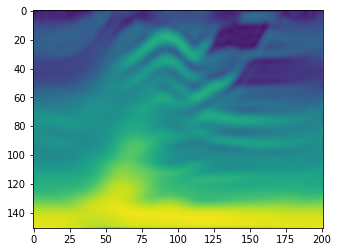

Processing Epoch: 1601
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1601 Loss:  0.00013545649380830582
Processing Epoch: 1602
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1602 Loss:  0.00013536988080886658
Processing Epoch: 1603
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1603 Loss:  0.00013528224735637195
Processing Epoch: 1604
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1604 Loss:  0.00013518563719117083
Proc

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1634 Loss:  0.00013264846529636998
Processing Epoch: 1635
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1635 Loss:  0.0001325610137428157
Processing Epoch: 1636
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1636 Loss:  0.00013248173308966216
Processing Epoch: 1637
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1637 Loss:  0.00013240463340480346
Processing Epoch: 1638
shape

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1667 Loss:  0.00012995126053283457
Processing Epoch: 1668
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1668 Loss:  0.00012986920773983002
Processing Epoch: 1669
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1669 Loss:  0.00012979495841136668
Processing Epoch: 1670
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1670 Loss:  0.00012972141848877072
Processing Epoch: 1671
shap

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1700 Loss:  0.00012736947246594355
Processing Epoch: 1701
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1701 Loss:  0.00012728646470350213
Processing Epoch: 1702
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1702 Loss:  0.00012721161147055682
Processing Epoch: 1703
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1703 Loss:  0.0001271312721655704
Processing Epoch: 1704
shape

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1733 Loss:  0.00012486611740314402
Processing Epoch: 1734
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1734 Loss:  0.00012478466851462144
Processing Epoch: 1735
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1735 Loss:  0.00012471512854972389
Processing Epoch: 1736
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1736 Loss:  0.00012464519568311516
Processing Epoch: 1737
shap

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1766 Loss:  0.00012245432480995078
Processing Epoch: 1767
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1767 Loss:  0.0001223859562742291
Processing Epoch: 1768
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1768 Loss:  0.00012230620632180944
Processing Epoch: 1769
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1769 Loss:  0.00012224207966937684
Processing Epoch: 1770
shape of predicted
torch.Size([4001, 4, 100])
shape

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1799 Loss:  0.00012013051855319645
Processing Epoch: 1800
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1800 Loss:  0.00012006273755105212


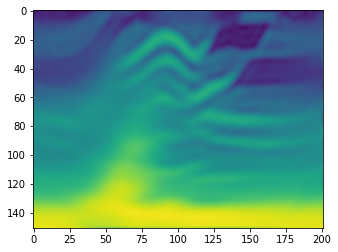

Processing Epoch: 1801
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1801 Loss:  0.00011999927482975181
Processing Epoch: 1802
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1802 Loss:  0.00011992260624538176
Processing Epoch: 1803
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1803 Loss:  0.00011985785567958374
Processing Epoch: 1804
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1804 Loss:  0.00011978754446317907
Proc

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1834 Loss:  0.00011775808525271714
Processing Epoch: 1835
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1835 Loss:  0.00011769102275138721
Processing Epoch: 1836
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1836 Loss:  0.00011762271242332645
Processing Epoch: 1837
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1837 Loss:  0.00011757479296647944
Processing Epoch: 1838
shap

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1867 Loss:  0.00011559815175132826
Processing Epoch: 1868
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1868 Loss:  0.00011553596777957864
Processing Epoch: 1869
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1869 Loss:  0.00011547601025085896
Processing Epoch: 1870
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1870 Loss:  0.00011540982450242154
Processing Epoch: 1871
shap

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1900 Loss:  0.00011351328248565551
Processing Epoch: 1901
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1901 Loss:  0.0001134506946982583
Processing Epoch: 1902
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1902 Loss:  0.00011338966578477994
Processing Epoch: 1903
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1903 Loss:  0.00011332928988849744
Processing Epoch: 1904
shape

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1933 Loss:  0.00011149689453304745
Processing Epoch: 1934
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1934 Loss:  0.00011144406016683206
Processing Epoch: 1935
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1935 Loss:  0.00011138243644381873
Processing Epoch: 1936
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1936 Loss:  0.00011131879364256747
Processing Epoch: 1937
shap

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1966 Loss:  0.00010955381912935991
Processing Epoch: 1967
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1967 Loss:  0.00010949233546853065
Processing Epoch: 1968
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1968 Loss:  0.00010943834968202282
Processing Epoch: 1969
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1969 Loss:  0.00010937950901279692
Processing Epoch: 1970
shap

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1999 Loss:  0.00010767320782179013
Processing Epoch: 2000
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2000 Loss:  0.00010761452722363174


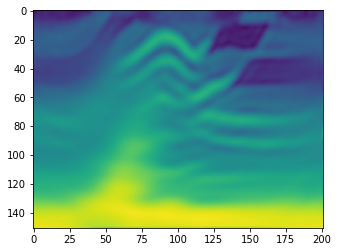

Processing Epoch: 2001
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2001 Loss:  0.00010755567927844822
Processing Epoch: 2002
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2002 Loss:  0.00010750327601272147
Processing Epoch: 2003
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2003 Loss:  0.00010744771316240076
Processing Epoch: 2004
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2004 Loss:  0.0001073906369128963
Proce

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2034 Loss:  0.00010574339103186503
Processing Epoch: 2035
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2035 Loss:  0.00010568524703558069
Processing Epoch: 2036
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2036 Loss:  0.00010563486284809187
Processing Epoch: 2037
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2037 Loss:  0.00010557981840975117
Processing Epoch: 2038
shap

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2067 Loss:  0.00010398283848189749
Processing Epoch: 2068
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2068 Loss:  0.00010392771037004422
Processing Epoch: 2069
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2069 Loss:  0.0001038776827044785
Processing Epoch: 2070
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2070 Loss:  0.0001038195059663849
Processing Epoch: 2071
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2100 Loss:  0.00010227493658021558
Processing Epoch: 2101
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2101 Loss:  0.0001022264677885687
Processing Epoch: 2102
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2102 Loss:  0.00010216950795438606
Processing Epoch: 2103
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2103 Loss:  0.00010212832785327919
Processing Epoch: 2104
shape

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2133 Loss:  0.00010061752254841849
Processing Epoch: 2134
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2134 Loss:  0.00010057519284600858
Processing Epoch: 2135
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2135 Loss:  0.00010052348989120219
Processing Epoch: 2136
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2136 Loss:  0.00010047323303297162
Processing Epoch: 2137
shap

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2166 Loss:  9.902090096147731e-05
Processing Epoch: 2167
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2167 Loss:  9.897536619973835e-05
Processing Epoch: 2168
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2168 Loss:  9.892587877402548e-05
Processing Epoch: 2169
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2169 Loss:  9.887432315736078e-05
Processing Epoch: 2170
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2199 Loss:  9.746618525241502e-05
Processing Epoch: 2200
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2200 Loss:  9.742246220412198e-05


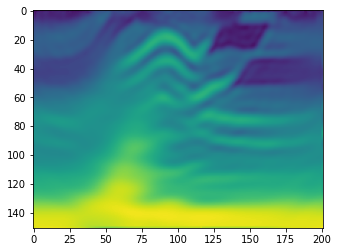

Processing Epoch: 2201
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2201 Loss:  9.73736350715626e-05
Processing Epoch: 2202
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2202 Loss:  9.73259793681791e-05
Processing Epoch: 2203
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2203 Loss:  9.72804209595779e-05
Processing Epoch: 2204
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2204 Loss:  9.723417861096095e-05
Processing 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2234 Loss:  9.586674059391953e-05
Processing Epoch: 2235
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2235 Loss:  9.582309394318145e-05
Processing Epoch: 2236
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2236 Loss:  9.577845958119724e-05
Processing Epoch: 2237
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2237 Loss:  9.573425268172286e-05
Processing Epoch: 2238
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2267 Loss:  9.44091661949642e-05
Processing Epoch: 2268
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2268 Loss:  9.436497748538386e-05
Processing Epoch: 2269
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2269 Loss:  9.4322986115003e-05
Processing Epoch: 2270
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2270 Loss:  9.427613076695707e-05
Processing Epoch: 2271
shape of predicted
torch.Size([4001, 4, 100])
shape of pr

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2300 Loss:  9.299256635131314e-05
Processing Epoch: 2301
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2301 Loss:  9.295000381825957e-05
Processing Epoch: 2302
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2302 Loss:  9.290778507420328e-05
Processing Epoch: 2303
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2303 Loss:  9.286694876209367e-05
Processing Epoch: 2304
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2333 Loss:  9.16134176804917e-05
Processing Epoch: 2334
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2334 Loss:  9.157656495517585e-05
Processing Epoch: 2335
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2335 Loss:  9.153183964372147e-05
Processing Epoch: 2336
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2336 Loss:  9.14896845642943e-05
Processing Epoch: 2337
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of p

Epoch: 2366 Loss:  9.028030945046339e-05
Processing Epoch: 2367
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2367 Loss:  9.023990514833713e-05
Processing Epoch: 2368
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2368 Loss:  9.020151173899649e-05
Processing Epoch: 2369
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2369 Loss:  9.01629937288817e-05
Processing Epoch: 2370
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 23

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2400 Loss:  8.893733865988906e-05


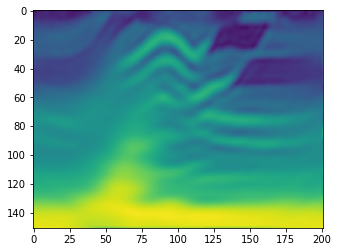

Processing Epoch: 2401
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2401 Loss:  8.88972954271594e-05
Processing Epoch: 2402
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2402 Loss:  8.885805254976731e-05
Processing Epoch: 2403
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2403 Loss:  8.88239874257124e-05
Processing Epoch: 2404
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2404 Loss:  8.878002699930221e-05
Processing

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2434 Loss:  8.763644018472405e-05
Processing Epoch: 2435
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2435 Loss:  8.760063064983115e-05
Processing Epoch: 2436
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2436 Loss:  8.755796625337098e-05
Processing Epoch: 2437
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2437 Loss:  8.752429585001664e-05
Processing Epoch: 2438
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2467 Loss:  8.640931628178805e-05
Processing Epoch: 2468
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2468 Loss:  8.637265000288608e-05
Processing Epoch: 2469
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2469 Loss:  8.63327531988034e-05
Processing Epoch: 2470
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2470 Loss:  8.629869626020081e-05
Processing Epoch: 2471
shape of predicted
torch.Size([4001, 4, 100])
shape of 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2500 Loss:  8.52137654874241e-05
Processing Epoch: 2501
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2501 Loss:  8.517801688867621e-05
Processing Epoch: 2502
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2502 Loss:  8.5143641626928e-05
Processing Epoch: 2503
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2503 Loss:  8.510755287716165e-05
Processing Epoch: 2504
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of pr

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2533 Loss:  8.404989057453349e-05
Processing Epoch: 2534
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2534 Loss:  8.40162447275361e-05
Processing Epoch: 2535
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2535 Loss:  8.398736463277601e-05
Processing Epoch: 2536
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2536 Loss:  8.394614451390225e-05
Processing Epoch: 2537
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of 

Epoch: 2566 Loss:  8.291578433272662e-05
Processing Epoch: 2567
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2567 Loss:  8.288585740956478e-05
Processing Epoch: 2568
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2568 Loss:  8.284940668090712e-05
Processing Epoch: 2569
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2569 Loss:  8.282120234071044e-05
Processing Epoch: 2570
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2600 Loss:  8.17813988760463e-05


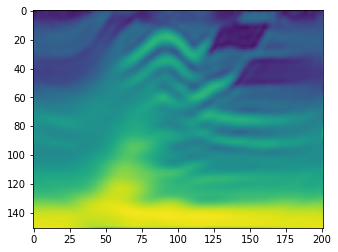

Processing Epoch: 2601
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2601 Loss:  8.174828326446004e-05
Processing Epoch: 2602
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2602 Loss:  8.17149702925235e-05
Processing Epoch: 2603
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2603 Loss:  8.168423664756119e-05
Processing Epoch: 2604
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2604 Loss:  8.165608869603602e-05
Processin

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2634 Loss:  8.067793169175275e-05
Processing Epoch: 2635
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2635 Loss:  8.064483336056583e-05
Processing Epoch: 2636
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2636 Loss:  8.061103017098503e-05
Processing Epoch: 2637
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2637 Loss:  8.057826198637486e-05
Processing Epoch: 2638
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2667 Loss:  7.963543066580314e-05
Processing Epoch: 2668
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2668 Loss:  7.960080074553844e-05
Processing Epoch: 2669
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2669 Loss:  7.956868194014532e-05
Processing Epoch: 2670
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2670 Loss:  7.953623753564898e-05
Processing Epoch: 2671
shape of predicted
torch.Size([4001, 4, 100])
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2700 Loss:  7.861365156713873e-05
Processing Epoch: 2701
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2701 Loss:  7.858022399886977e-05
Processing Epoch: 2702
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2702 Loss:  7.85471020208206e-05
Processing Epoch: 2703
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2703 Loss:  7.851997088437201e-05
Processing Epoch: 2704
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of 

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2733 Loss:  7.76162269175984e-05
Processing Epoch: 2734
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2734 Loss:  7.758836636639899e-05
Processing Epoch: 2735
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2735 Loss:  7.755835940770339e-05
Processing Epoch: 2736
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2736 Loss:  7.752905912639108e-05
Processing Epoch: 2737
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of 

Epoch: 2766 Loss:  7.664745044166921e-05
Processing Epoch: 2767
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2767 Loss:  7.661580002604751e-05
Processing Epoch: 2768
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2768 Loss:  7.658683171030134e-05
Processing Epoch: 2769
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2769 Loss:  7.656226989638526e-05
Processing Epoch: 2770
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2800 Loss:  7.567041029687971e-05


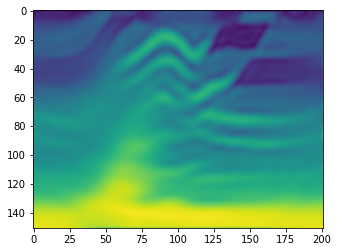

Processing Epoch: 2801
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2801 Loss:  7.564171119156526e-05
Processing Epoch: 2802
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2802 Loss:  7.561842085124226e-05
Processing Epoch: 2803
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2803 Loss:  7.55862747610081e-05
Processing Epoch: 2804
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2804 Loss:  7.556107084383257e-05
Processin

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2834 Loss:  7.472020661225542e-05
Processing Epoch: 2835
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2835 Loss:  7.469022875739029e-05
Processing Epoch: 2836
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2836 Loss:  7.466591432603309e-05
Processing Epoch: 2837
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2837 Loss:  7.463835845555877e-05
Processing Epoch: 2838
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2867 Loss:  7.38177450330113e-05
Processing Epoch: 2868
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2868 Loss:  7.379283670161385e-05
Processing Epoch: 2869
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2869 Loss:  7.3765932029346e-05
Processing Epoch: 2870
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2870 Loss:  7.373856988124317e-05
Processing Epoch: 2871
shape of predicted
torch.Size([4001, 4, 100])
shape of pr

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2900 Loss:  7.294198076124303e-05
Processing Epoch: 2901
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2901 Loss:  7.291056408575969e-05
Processing Epoch: 2902
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2902 Loss:  7.28867689758772e-05
Processing Epoch: 2903
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2903 Loss:  7.286791696969885e-05
Processing Epoch: 2904
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of 

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2933 Loss:  7.208361603261437e-05
Processing Epoch: 2934
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2934 Loss:  7.205164365586825e-05
Processing Epoch: 2935
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2935 Loss:  7.202505639725132e-05
Processing Epoch: 2936
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2936 Loss:  7.20022699169931e-05
Processing Epoch: 2937
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of 

Epoch: 2966 Loss:  7.123752038751263e-05
Processing Epoch: 2967
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2967 Loss:  7.121325688785873e-05
Processing Epoch: 2968
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2968 Loss:  7.119057772797532e-05
Processing Epoch: 2969
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2969 Loss:  7.116583401511889e-05
Processing Epoch: 2970
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3000 Loss:  7.039161300781416e-05


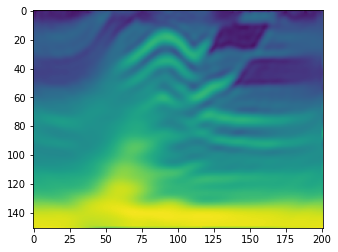

Processing Epoch: 3001
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3001 Loss:  7.036758051981451e-05
Processing Epoch: 3002
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3002 Loss:  7.034838017716538e-05
Processing Epoch: 3003
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3003 Loss:  7.032545090623898e-05
Processing Epoch: 3004
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3004 Loss:  7.02940096743987e-05
Processin

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3034 Loss:  6.956668130442267e-05
Processing Epoch: 3035
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3035 Loss:  6.954377204237971e-05
Processing Epoch: 3036
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3036 Loss:  6.952383955649566e-05
Processing Epoch: 3037
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3037 Loss:  6.949848011572612e-05
Processing Epoch: 3038
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3067 Loss:  6.878098156448686e-05
Processing Epoch: 3068
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3068 Loss:  6.87626888975501e-05
Processing Epoch: 3069
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3069 Loss:  6.87369838487939e-05
Processing Epoch: 3070
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3070 Loss:  6.871069945191266e-05
Processing Epoch: 3071
shape of predicted
torch.Size([4001, 4, 100])
shape of p

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3100 Loss:  6.801651852583745e-05
Processing Epoch: 3101
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3101 Loss:  6.799322181905154e-05
Processing Epoch: 3102
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3102 Loss:  6.796822344767861e-05
Processing Epoch: 3103
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3103 Loss:  6.79473396303365e-05
Processing Epoch: 3104
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of 

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3133 Loss:  6.726514493493596e-05
Processing Epoch: 3134
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3134 Loss:  6.724374907207675e-05
Processing Epoch: 3135
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3135 Loss:  6.72193054924719e-05
Processing Epoch: 3136
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3136 Loss:  6.71982697895146e-05
Processing Epoch: 3137
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of p

Epoch: 3166 Loss:  6.653667514910921e-05
Processing Epoch: 3167
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3167 Loss:  6.651689636782976e-05
Processing Epoch: 3168
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3168 Loss:  6.64872150082374e-05
Processing Epoch: 3169
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3169 Loss:  6.64636700093979e-05
Processing Epoch: 3170
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 317

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3200 Loss:  6.579098953807261e-05


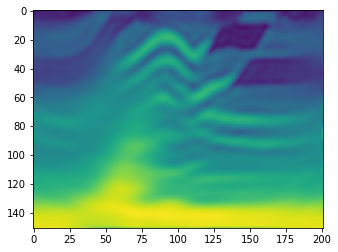

Processing Epoch: 3201
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3201 Loss:  6.577071508218069e-05
Processing Epoch: 3202
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3202 Loss:  6.574716553586768e-05
Processing Epoch: 3203
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3203 Loss:  6.572729398612864e-05
Processing Epoch: 3204
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3204 Loss:  6.570523055415833e-05
Processi

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3234 Loss:  6.506643148895819e-05
Processing Epoch: 3235
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3235 Loss:  6.504500743176322e-05
Processing Epoch: 3236
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3236 Loss:  6.50231395411538e-05
Processing Epoch: 3237
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3237 Loss:  6.50046240480151e-05
Processing Epoch: 3238
shape of p

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3267 Loss:  6.437571664719144e-05
Processing Epoch: 3268
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3268 Loss:  6.43566163489595e-05
Processing Epoch: 3269
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3269 Loss:  6.433599810407031e-05
Processing Epoch: 3270
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3270 Loss:  6.431332712963922e-05
Processing Epoch: 3271
shape of predicted
torch.Size([4001, 4, 100])
shape of 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3300 Loss:  6.370209302986041e-05
Processing Epoch: 3301
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3301 Loss:  6.368056619976414e-05
Processing Epoch: 3302
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3302 Loss:  6.366119760059519e-05
Processing Epoch: 3303
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3303 Loss:  6.36446884527686e-05
Processing Epoch: 3304
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of 

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3333 Loss:  6.304275302682072e-05
Processing Epoch: 3334
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3334 Loss:  6.302631209109677e-05
Processing Epoch: 3335
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3335 Loss:  6.300291170191485e-05
Processing Epoch: 3336
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3336 Loss:  6.298460721154697e-05
Processing Epoch: 3337
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of

Epoch: 3366 Loss:  6.239317917788867e-05
Processing Epoch: 3367
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3367 Loss:  6.237354318727739e-05
Processing Epoch: 3368
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3368 Loss:  6.235835462575778e-05
Processing Epoch: 3369
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3369 Loss:  6.233504245756194e-05
Processing Epoch: 3370
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3400 Loss:  6.173806013975991e-05


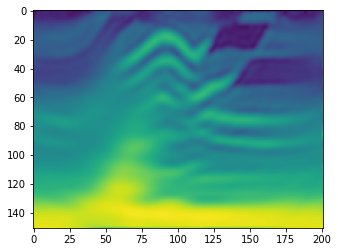

Processing Epoch: 3401
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3401 Loss:  6.171951372380136e-05
Processing Epoch: 3402
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3402 Loss:  6.170311098685488e-05
Processing Epoch: 3403
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3403 Loss:  6.168200525280554e-05
Processing Epoch: 3404
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3404 Loss:  6.166952789499192e-05
Processi

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3434 Loss:  6.11032291999436e-05
Processing Epoch: 3435
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3435 Loss:  6.107873014116194e-05
Processing Epoch: 3436
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3436 Loss:  6.106186356191756e-05
Processing Epoch: 3437
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3437 Loss:  6.104386193328537e-05
Processing Epoch: 3438
shape of 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3467 Loss:  6.0489784118544776e-05
Processing Epoch: 3468
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3468 Loss:  6.04705091973301e-05
Processing Epoch: 3469
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3469 Loss:  6.045099235052476e-05
Processing Epoch: 3470
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3470 Loss:  6.043487974238815e-05
Processing Epoch: 3471
shape of predicted
torch.Size([4001, 4, 100])
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3500 Loss:  5.989279452478513e-05
Processing Epoch: 3501
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3501 Loss:  5.9875131228182e-05
Processing Epoch: 3502
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3502 Loss:  5.985806456010323e-05
Processing Epoch: 3503
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3503 Loss:  5.9837352637259755e-05
Processing Epoch: 3504
shape of predicted
torch.Size([4001, 4, 100])
shape of 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3533 Loss:  5.930282077315496e-05
Processing Epoch: 3534
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3534 Loss:  5.9287826843501534e-05
Processing Epoch: 3535
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3535 Loss:  5.927009442530107e-05
Processing Epoch: 3536
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3536 Loss:  5.9255538872093894e-05
Processing Epoch: 3537
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3566 Loss:  5.873068221262656e-05
Processing Epoch: 3567
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3567 Loss:  5.8715863815450575e-05
Processing Epoch: 3568
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3568 Loss:  5.869431151950266e-05
Processing Epoch: 3569
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3569 Loss:  5.8678754612628836e-05
Processing Epoch: 3570
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3599 Loss:  5.8165071095572785e-05
Processing Epoch: 3600
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3600 Loss:  5.814814448967809e-05


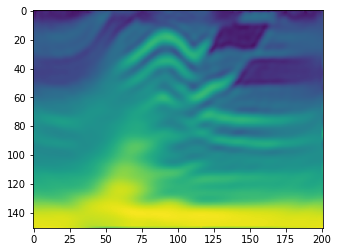

Processing Epoch: 3601
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3601 Loss:  5.8131024161411915e-05
Processing Epoch: 3602
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3602 Loss:  5.81158819841221e-05
Processing Epoch: 3603
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3603 Loss:  5.809865797345992e-05
Processing Epoch: 3604
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3604 Loss:  5.8079222981177736e-05
Process

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3634 Loss:  5.757770122727379e-05
Processing Epoch: 3635
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3635 Loss:  5.755998154199915e-05
Processing Epoch: 3636
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3636 Loss:  5.7543398725101724e-05
Processing Epoch: 3637
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3637 Loss:  5.752701054007048e-05
Processing Epoch: 3638
shape o

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3667 Loss:  5.703477290808223e-05
Processing Epoch: 3668
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3668 Loss:  5.7018435654754285e-05
Processing Epoch: 3669
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3669 Loss:  5.699871508113574e-05
Processing Epoch: 3670
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3670 Loss:  5.698347740690224e-05
Processing Epoch: 3671
shape of predicted
torch.Size([4001, 4, 100])
shape o

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3700 Loss:  5.650030379911186e-05
Processing Epoch: 3701
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3701 Loss:  5.648472233588109e-05
Processing Epoch: 3702
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3702 Loss:  5.6466808018740267e-05
Processing Epoch: 3703
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3703 Loss:  5.645223518513376e-05
Processing Epoch: 3704
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape o

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3733 Loss:  5.5976542171265464e-05
Processing Epoch: 3734
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3734 Loss:  5.596085702563869e-05
Processing Epoch: 3735
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3735 Loss:  5.594611411652295e-05
Processing Epoch: 3736
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3736 Loss:  5.5931076531123836e-05
Processing Epoch: 3737
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape 

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3766 Loss:  5.5462310228904244e-05
Processing Epoch: 3767
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3767 Loss:  5.5446197620767634e-05
Processing Epoch: 3768
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3768 Loss:  5.5432619774364866e-05
Processing Epoch: 3769
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3769 Loss:  5.5415162023564335e-05
Processing Epoch: 3770
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shap

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3799 Loss:  5.495895311469212e-05
Processing Epoch: 3800
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3800 Loss:  5.4943359828030225e-05


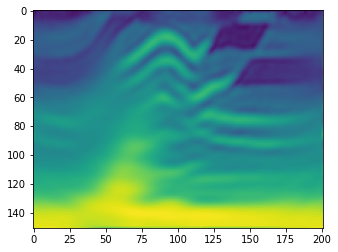

Processing Epoch: 3801
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3801 Loss:  5.492533182405168e-05
Processing Epoch: 3802
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3802 Loss:  5.4913313761062454e-05
Processing Epoch: 3803
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3803 Loss:  5.4895025641599204e-05
Processing Epoch: 3804
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3804 Loss:  5.4879784329386894e-05
Proce

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3834 Loss:  5.442914061859483e-05
Processing Epoch: 3835
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3835 Loss:  5.441570556286024e-05
Processing Epoch: 3836
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3836 Loss:  5.439898632175755e-05
Processing Epoch: 3837
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3837 Loss:  5.438345033326186e-05
Processing Epoch: 3838
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3867 Loss:  5.394085201260168e-05
Processing Epoch: 3868
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3868 Loss:  5.392666844272753e-05
Processing Epoch: 3869
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3869 Loss:  5.39164429937955e-05
Processing Epoch: 3870
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3870 Loss:  5.3897962970950175e-05
Processing Epoch: 3871
shape of predicted
torch.Size([4001, 4, 100])
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3900 Loss:  5.346256057237042e-05
Processing Epoch: 3901
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3901 Loss:  5.34471073478926e-05
Processing Epoch: 3902
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3902 Loss:  5.343362863641232e-05
Processing Epoch: 3903
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3903 Loss:  5.342135045793839e-05
Processing Epoch: 3904
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of 

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3933 Loss:  5.299317308526952e-05
Processing Epoch: 3934
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3934 Loss:  5.297756433719769e-05
Processing Epoch: 3935
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3935 Loss:  5.296308154356666e-05
Processing Epoch: 3936
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3936 Loss:  5.294820130075095e-05
Processing Epoch: 3937
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of

Epoch: 3966 Loss:  5.252705432212679e-05
Processing Epoch: 3967
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3967 Loss:  5.2513935770548414e-05
Processing Epoch: 3968
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3968 Loss:  5.2498843615467194e-05
Processing Epoch: 3969
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3969 Loss:  5.24877641510102e-05
Processing Epoch: 3970
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 

Epoch: 3999 Loss:  5.207240883464692e-05
Processing Epoch: 4000
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4000 Loss:  5.206042442296166e-05


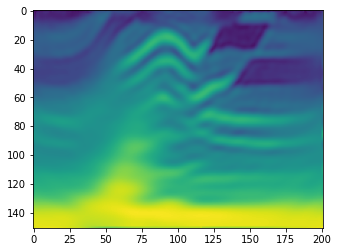

Processing Epoch: 4001
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4001 Loss:  5.204480567044811e-05
Processing Epoch: 4002
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4002 Loss:  5.203056934988126e-05
Processing Epoch: 4003
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4003 Loss:  5.201795829634648e-05
Processing Epoch: 4004
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4004 Loss:  5.200530904403422e-05
Processi

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4034 Loss:  5.15983419973054e-05
Processing Epoch: 4035
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4035 Loss:  5.158384283276973e-05
Processing Epoch: 4036
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4036 Loss:  5.157165651326068e-05
Processing Epoch: 4037
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4037 Loss:  5.155799226486124e-05
Processing Epoch: 4038
shape of 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4067 Loss:  5.115803560329368e-05
Processing Epoch: 4068
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4068 Loss:  5.114331452205079e-05
Processing Epoch: 4069
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4069 Loss:  5.113107090437552e-05
Processing Epoch: 4070
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4070 Loss:  5.111722020956222e-05
Processing Epoch: 4071
shape of predicted
torch.Size([4001, 4, 100])
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4100 Loss:  5.072329986433033e-05
Processing Epoch: 4101
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4101 Loss:  5.071057876193663e-05
Processing Epoch: 4102
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4102 Loss:  5.069858980277786e-05
Processing Epoch: 4103
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4103 Loss:  5.0684818234003615e-05
Processing Epoch: 4104
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape o

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4133 Loss:  5.029846306570107e-05
Processing Epoch: 4134
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4134 Loss:  5.028485793445725e-05
Processing Epoch: 4135
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4135 Loss:  5.02728289575316e-05
Processing Epoch: 4136
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4136 Loss:  5.025920836487785e-05
Processing Epoch: 4137
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4166 Loss:  4.9880987717187963e-05
Processing Epoch: 4167
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4167 Loss:  4.986577459931141e-05
Processing Epoch: 4168
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4168 Loss:  4.985436135029886e-05
Processing Epoch: 4169
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4169 Loss:  4.984021325071808e-05
Processing Epoch: 4170
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape o

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4199 Loss:  4.946514491166454e-05
Processing Epoch: 4200
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4200 Loss:  4.945271484757541e-05


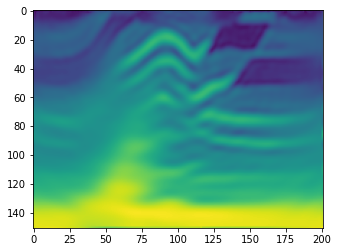

Processing Epoch: 4201
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4201 Loss:  4.944133161188802e-05
Processing Epoch: 4202
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4202 Loss:  4.943045405525481e-05
Processing Epoch: 4203
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4203 Loss:  4.941798033542e-05
Processing Epoch: 4204
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4204 Loss:  4.940500730299391e-05
Processing 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4234 Loss:  4.903745957562933e-05
Processing Epoch: 4235
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4235 Loss:  4.9025234147848096e-05
Processing Epoch: 4236
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4236 Loss:  4.901223837805446e-05
Processing Epoch: 4237
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4237 Loss:  4.900261774309911e-05
Processing Epoch: 4238
shape o

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4267 Loss:  4.8637750751368e-05
Processing Epoch: 4268
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4268 Loss:  4.862540117755998e-05
Processing Epoch: 4269
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4269 Loss:  4.861170600634068e-05
Processing Epoch: 4270
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4270 Loss:  4.860212766288896e-05
Processing Epoch: 4271
shape of p

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4300 Loss:  4.824632196687162e-05
Processing Epoch: 4301
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4301 Loss:  4.8240081923722755e-05
Processing Epoch: 4302
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4302 Loss:  4.8222465011349414e-05
Processing Epoch: 4303
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4303 Loss:  4.820788490178529e-05
Processing Epoch: 4304
shape of predicted
torch.Size([4001, 4, 100])
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4333 Loss:  4.785841974808136e-05
Processing Epoch: 4334
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4334 Loss:  4.784382508660201e-05
Processing Epoch: 4335
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4335 Loss:  4.783377698913682e-05
Processing Epoch: 4336
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4336 Loss:  4.782208907272434e-05
Processing Epoch: 4337
shape of predicted
torch.Size([4001, 4, 100])
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4366 Loss:  4.7475896280957386e-05
Processing Epoch: 4367
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4367 Loss:  4.746626473206561e-05
Processing Epoch: 4368
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4368 Loss:  4.745303522213362e-05
Processing Epoch: 4369
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4369 Loss:  4.744184570881771e-05
Processing Epoch: 4370
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape o

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4399 Loss:  4.709939548774855e-05
Processing Epoch: 4400
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4400 Loss:  4.708860706159612e-05


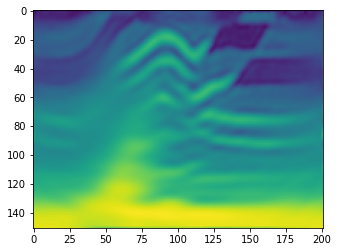

Processing Epoch: 4401
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4401 Loss:  4.707833068096079e-05
Processing Epoch: 4402
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4402 Loss:  4.706546951638302e-05
Processing Epoch: 4403
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4403 Loss:  4.705495302914642e-05
Processing Epoch: 4404
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4404 Loss:  4.7043542508617975e-05
Process

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4434 Loss:  4.670904309023172e-05
Processing Epoch: 4435
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4435 Loss:  4.6699310587428045e-05
Processing Epoch: 4436
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4436 Loss:  4.66848205178394e-05
Processing Epoch: 4437
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4437 Loss:  4.667770735977683e-05
Processing Epoch: 4438
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4467 Loss:  4.634251854440663e-05
Processing Epoch: 4468
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4468 Loss:  4.63355281681288e-05
Processing Epoch: 4469
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4469 Loss:  4.632326181308599e-05
Processing Epoch: 4470
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4470 Loss:  4.631171759683639e-05
Processing Epoch: 4471
shape of predicted
torch.Size([4001, 4, 100])
shape of 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4500 Loss:  4.59839748145896e-05
Processing Epoch: 4501
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4501 Loss:  4.597350380208809e-05
Processing Epoch: 4502
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4502 Loss:  4.5964841774548404e-05
Processing Epoch: 4503
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4503 Loss:  4.595358541337191e-05
Processing Epoch: 4504
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4533 Loss:  4.563363654597197e-05
Processing Epoch: 4534
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4534 Loss:  4.56219568150118e-05
Processing Epoch: 4535
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4535 Loss:  4.561155401461292e-05
Processing Epoch: 4536
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4536 Loss:  4.560135039355373e-05
Processing Epoch: 4537
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of 

Epoch: 4566 Loss:  4.5285730266186874e-05
Processing Epoch: 4567
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4567 Loss:  4.528037788986694e-05
Processing Epoch: 4568
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4568 Loss:  4.526341854216298e-05
Processing Epoch: 4569
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4569 Loss:  4.525187159742927e-05
Processing Epoch: 4570
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 

Epoch: 4599 Loss:  4.4942073145648465e-05
Processing Epoch: 4600
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4600 Loss:  4.49294711870607e-05


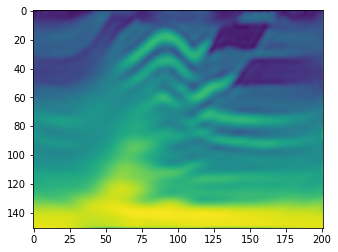

Processing Epoch: 4601
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4601 Loss:  4.4920373966306215e-05
Processing Epoch: 4602
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4602 Loss:  4.491031086217845e-05
Processing Epoch: 4603
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4603 Loss:  4.489912862482015e-05
Processing Epoch: 4604
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4604 Loss:  4.488832473725779e-05
Process

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4634 Loss:  4.458136208995711e-05
Processing Epoch: 4635
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4635 Loss:  4.457188242668053e-05
Processing Epoch: 4636
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4636 Loss:  4.4561516915564425e-05
Processing Epoch: 4637
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4637 Loss:  4.455098633115995e-05
Processing Epoch: 4638
shape o

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4667 Loss:  4.424993858265225e-05
Processing Epoch: 4668
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4668 Loss:  4.423853579282877e-05
Processing Epoch: 4669
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4669 Loss:  4.422789152158657e-05
Processing Epoch: 4670
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4670 Loss:  4.421820722200209e-05
Processing Epoch: 4671
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4700 Loss:  4.392114715301432e-05
Processing Epoch: 4701
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4701 Loss:  4.391113907331601e-05
Processing Epoch: 4702
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4702 Loss:  4.3900553919229424e-05
Processing Epoch: 4703
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4703 Loss:  4.3890741835639346e-05
Processing Epoch: 4704
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4733 Loss:  4.359607828519074e-05
Processing Epoch: 4734
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4734 Loss:  4.358870046416996e-05
Processing Epoch: 4735
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4735 Loss:  4.3576415919233114e-05
Processing Epoch: 4736
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4736 Loss:  4.356580939202104e-05
Processing Epoch: 4737
shape o

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4766 Loss:  4.327867554820841e-05
Processing Epoch: 4767
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4767 Loss:  4.326774296714575e-05
Processing Epoch: 4768
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4768 Loss:  4.325743020672235e-05
Processing Epoch: 4769
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4769 Loss:  4.324737074057339e-05
Processing Epoch: 4770
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4799 Loss:  4.296213319321396e-05
Processing Epoch: 4800
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4800 Loss:  4.295281360100489e-05


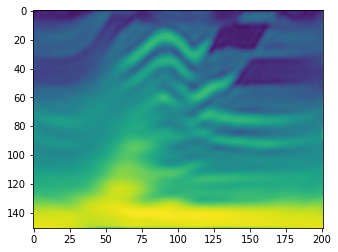

Processing Epoch: 4801
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4801 Loss:  4.2942258914990816e-05
Processing Epoch: 4802
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4802 Loss:  4.293364418117562e-05
Processing Epoch: 4803
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4803 Loss:  4.2924026729451725e-05
Processing Epoch: 4804
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4804 Loss:  4.2915885387628805e-05
Proce

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4834 Loss:  4.2632212625903776e-05
Processing Epoch: 4835
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4835 Loss:  4.2621829379640985e-05
Processing Epoch: 4836
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4836 Loss:  4.261341382516548e-05
Processing Epoch: 4837
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4837 Loss:  4.260559944668785e-05
Processing Epoch: 4838
shape 

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4867 Loss:  4.2326515540480614e-05
Processing Epoch: 4868
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4868 Loss:  4.231853108649375e-05
Processing Epoch: 4869
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4869 Loss:  4.2310059143346734e-05
Processing Epoch: 4870
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4870 Loss:  4.2302560359530617e-05
Processing Epoch: 4871
shape of predicted
torch.Size([4001, 4, 100])
shape

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4900 Loss:  4.202473246550653e-05
Processing Epoch: 4901
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4901 Loss:  4.2014972677861806e-05
Processing Epoch: 4902
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4902 Loss:  4.2005820432677865e-05
Processing Epoch: 4903
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4903 Loss:  4.19978368881857e-05
Processing Epoch: 4904
shape of predicted
torch.Size([4001, 4, 100])
shape o

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4933 Loss:  4.172837725491263e-05
Processing Epoch: 4934
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4934 Loss:  4.171688533460838e-05
Processing Epoch: 4935
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4935 Loss:  4.170822830928955e-05
Processing Epoch: 4936
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4936 Loss:  4.169998828729149e-05
Processing Epoch: 4937
shape of predicted
torch.Size([4001, 4, 100])
shape of

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4966 Loss:  4.1434051126998384e-05
Processing Epoch: 4967
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4967 Loss:  4.142363059145282e-05
Processing Epoch: 4968
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4968 Loss:  4.1416086787648965e-05
Processing Epoch: 4969
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4969 Loss:  4.1407883600186324e-05
Processing Epoch: 4970
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4999 Loss:  4.11447317674174e-05
Runtime: 9851.393891572952


In [74]:
#%%capture cap --no-stderr 
# The line above captures the output of this cell to the variable cap

# Iterative inversion loop
t_start = time.time()

##num_batches = 32 # split data into batches for speed and reduced memory use
num_shots_per_batch = int(num_shots / num_batches)
##num_epochs = 1000 # Pass through the entire dataset 30 times

#vmin, vmax = np.percentile(model_true.numpy(), [2,98]) # For plotting
vmin = min1
vmax = max1
#vmin=-1
#vmax= 1
# Temperature coefficient
##Tk =50



for epoch in range(num_epochs):
    ep_start=time.time()
    print('Processing Epoch:',epoch)
    epoch_loss = 0.0
    
    #RB Shuffle shot coordinates
    idx = torch.randperm(num_shots)
    x_s = x_s.view(-1,2)[idx].view(x_s.size())
    #RB Shuffle true's seismograms sources with same random values
    rcv_amps_true_norm = rcv_amps_true_norm[:,idx,:]
    #RB Shuffle direct wave seismograms sources with the same random values
    #receiver_amplitudes_cte = receiver_amplitudes_cte[:,idx,:]
    #print(np.shape(rcv_amps_true_norm))
    
    for it in range(num_batches):
        it_start = time.time()
        ###print('    Processing Batch:',it,' of', num_batches)
        
        optimizer.zero_grad()
        #if model.grad is not None:
        #    model.grad.data.zero_()
        #    print('Preexinting Model Grad zeroed')
            
        #RB Denormalize model to perform forward propagation
        #model2=model*wid+med
        #RB or no denormalization if using Adam
        model2=model.clone()
        #RB Clamp the model within acceptable range
        model2=torch.clamp(model,min=min1,max=max1)        
        
        #RB Make sure the model have same range of velocities of true's model (fix propag issue)
        #RB forcing one of its slowest pixel to have the true's model lower velocity and
        #RB forcing one of its fastest pixel to have the true's model upper velocity       
        #RB find max & min values of model2
        #smin=torch.min(model2)
        #smax=torch.max(model2)
        #indmin = torch.where(model2==smin)
        #indmax = torch.where(model2==smax)
        # Take first pixel with minimum velocity and force it to true's model minimum velocity
        #model2[indmin[0][0],indmin[1][0]]=min1
        # Take first pixel with maximum velocity and force it to true's model maximum velocity
        #model2[indmax[0][0],indmax[1][0]]=max1
        
        prop3 = deepwave.scalar.Propagator({'vp': model2}, dx)
        batch_src_amps = source_amplitudes.repeat(1, num_shots_per_batch, 1)
        batch_rcv_amps_true = rcv_amps_true_norm[:,it::num_batches].to(device)
        
        #RB Alternative normalization (normalizing to dTrue amplitude range)
        #batch_rcv_amps_true_max, _ = batch_rcv_amps_true.max(dim=0, keepdim=True)
        
        #RB get the seismogram of the direct wave for current batch
        #############batch_rcv_amps_cte = receiver_amplitudes_cte[:,it::num_batches].to(device)
        
        #RB get the current batch source & receiver coordinates
        batch_x_s = x_s[it::num_batches].to(device)
        batch_x_r = x_r[it::num_batches].to(device)

        #print('FWD Propag')
        #timer_a = time.time()
        
        batch_rcv_amps_pred = prop3(batch_src_amps, batch_x_s, batch_x_r, dt)
        
        #RB Subtract direct wave on all seismograms of current batch
        batch_rcv_amps_pred = batch_rcv_amps_pred
        
        #RB Normalize
        batch_rcv_amps_pred_max, _ = batch_rcv_amps_pred.max(dim=0, keepdim=True)
        batch_rcv_amps_pred_norm = batch_rcv_amps_pred / batch_rcv_amps_pred_max
        
        print("shape of predicted")
        print(np.shape(batch_rcv_amps_pred_norm))

        loss = criterion(batch_rcv_amps_pred_norm, batch_rcv_amps_true)            
        epoch_loss += loss.item()
        
        #timer_a = time.time()
        #print('Lap=',timer_a-timer_b)
        
        
        #print('Backpropagation')
    
        loss.backward()
        #model.grad[0:26,:]=0.
        
        
        #timer_b = time.time()
        #print('Lap=',timer_b-timer_a)
        
        #RB Hill climbing factor computation
        #low = 1-2*np.exp(-epoch/Tk)
        #alpha = np.random.uniform(low=low,high=1)
        #alpha = 1.
        
        #print('Model update')
        #with torch.no_grad():                
            #RB update model
        #    model =  model - torch.tanh(alpha*gamma*model.grad)                
        #model.requires_grad = True        
        optimizer.step()
        
        
        # Clamp model to acceptable range
        #with torch.no_grad():
        #    model=torch.clamp(model,min=min,max=max)
        #model.requires_grad = True
        
        it_end = time.time()
        #print('Lap=',it_end-timer_b)
        
        
    #RB Write variables to file at each epoch
    fields=[epoch,it,loss.item(),epoch_loss, it_end - it_start,it_end - ep_start]
    writer.writerow(fields)
    f.flush()
    os.fsync(f)
    
    print('Epoch:', epoch, 'Loss: ', epoch_loss)
    img = np.array(model.cpu().detach().numpy())

       
    if epoch % 200 == 0:
        
        if plot==True:
            plt.figure(figsize=(8, 4))
            plt.imshow(model.cpu().detach().numpy(), vmin=vmin, vmax=vmax,cmap='viridis')
            plt.show() 
            
        filename='Marmsm_Mod8_epoch_'+str(epoch)+'.mat'
        scipy.io.savemat(filename, mdict={'Model': img})
    
    epoch+=1

t_end = time.time()
print('Runtime:', t_end - t_start)

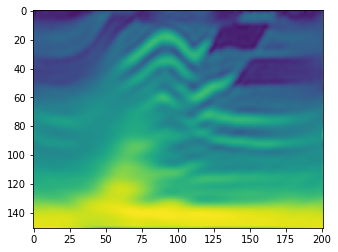

In [76]:
plt.imshow(img)

In [145]:
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/')


os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainA')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainB')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainC')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthurst/trainD')

os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testA')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testB')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testC')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testD')

os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainA')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainB')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainC')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainD')

os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testA')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testB')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testC')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testD')

0

In [146]:
seis = seis.swapaxes(0,1)
#mat3 = 2200*np.ones(np.shape(mat))
#mat3[0:26,:] = 1500
A = mat
B = mat3
C = seis

for kk in range(1,2):
    
    #kk = 1
    D = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/ZZConstant0ep'+str(kk)+'.npy')
            
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainA/'+str(kk)+'.npy','wb')
    np.save(file,A)
    file.close()

    
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainB/'+str(kk)+'.npy','wb')
    np.save(file,B)
    file.close()


    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainC/'+str(kk)+'.npy','wb')
    np.save(file,C)
    file.close()

    
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainD/'+str(kk)+'.npy','wb')
    np.save(file,D)
    file.close()


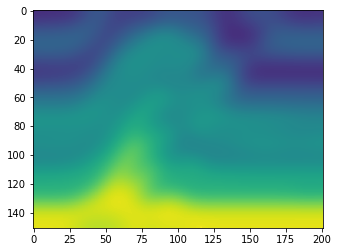

In [147]:
plt.imshow(mat3)

In [148]:
for kk in range(150,151):
    
    #kk = 1
    D = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/ZZConstant0ep'+str(kk)+'.npy')
            
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testA/'+str(kk)+'.npy','wb')
    np.save(file,A)
    file.close()
    

    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testB/'+str(kk)+'.npy','wb')
    np.save(file,B)
    file.close()


    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testC/'+str(kk)+'.npy','wb')
    np.save(file,C)
    file.close()
    

    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testD/'+str(kk)+'.npy','wb')
    np.save(file,D)
    file.close()